In [1]:
# se importan las librerias necesarias

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
from matplotlib.pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense


In [2]:
# se cargan los datos. En este caso la cotización de tesla desde el año 2012 hasta diciembre de 2021.
# Vemos que los datos ya vienen bien ordenados y limpios. En este caso no vamos a necesitar hacer features engineering.
# Siempre que se descarguen los datos directamente de yahoo finance tienen esta estructura.


In [3]:

df = pd.read_csv("data/TSLA_2012.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,1.929333,1.966667,1.843333,1.872000,1.872000,13921500
1,2012-01-04,1.880667,1.911333,1.833333,1.847333,1.847333,9451500
2,2012-01-05,1.850667,1.862000,1.790000,1.808000,1.808000,15082500
3,2012-01-06,1.813333,1.852667,1.760667,1.794000,1.794000,14794500
4,2012-01-09,1.800000,1.832667,1.741333,1.816667,1.816667,13455000
...,...,...,...,...,...,...,...
2511,2021-12-23,335.600006,357.660004,332.519989,355.666656,355.666656,92713200
2512,2021-12-27,357.890015,372.333344,356.906677,364.646667,364.646667,71145900
2513,2021-12-28,369.829987,373.000000,359.473328,362.823334,362.823334,60324000
2514,2021-12-29,366.213318,368.000000,354.713318,362.063324,362.063324,56154000


In [4]:
# vamos a ver los principales datos estadísticos de nuestro dataframe.
# se puede apreciar la gran diferencia que hay entre el valor mínimo y el valor máximo. Hay que ir pensando en un escalado....
# la media esta bastante lejos del maximo asi que podemos esperar que en alguno momento el precio va a crecer mucho y rápidamente.

df.describe()


,Open,High,Low,Close,Adj Close,Volume
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03
mean,46.940215,47.939108,45.885582,46.980275,46.980275,1.053292e+08
std,79.028350,80.761725,77.179887,79.114164,79.114164,8.497500e+07
min,1.774667,1.790000,1.509333,1.519333,1.519333,5.473500e+06
25%,13.094167,13.300500,12.846667,13.093833,13.093833,5.376600e+07
50%,16.597000,16.836666,16.376000,16.594334,16.594334,8.423730e+07
75%,23.169334,23.489668,22.816000,23.164500,23.164500,1.287229e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


In [5]:
# se comprueba que no haya columnas con valores nulos. en este caso vienen limpios.
# si se da el caso de haber presencia de valores vacios lo mejor es sustituirlos por los valores anteriores, ya que las series temporales son bastante sensibles a cambios.

df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
# se le da el formato de fecha.
# es necesario hacerlo para despues predecir valores bursatiles.

df["Date"] = pd.to_datetime(df.Date, format="%Y-%m-%d")
df.index = df["Date"]

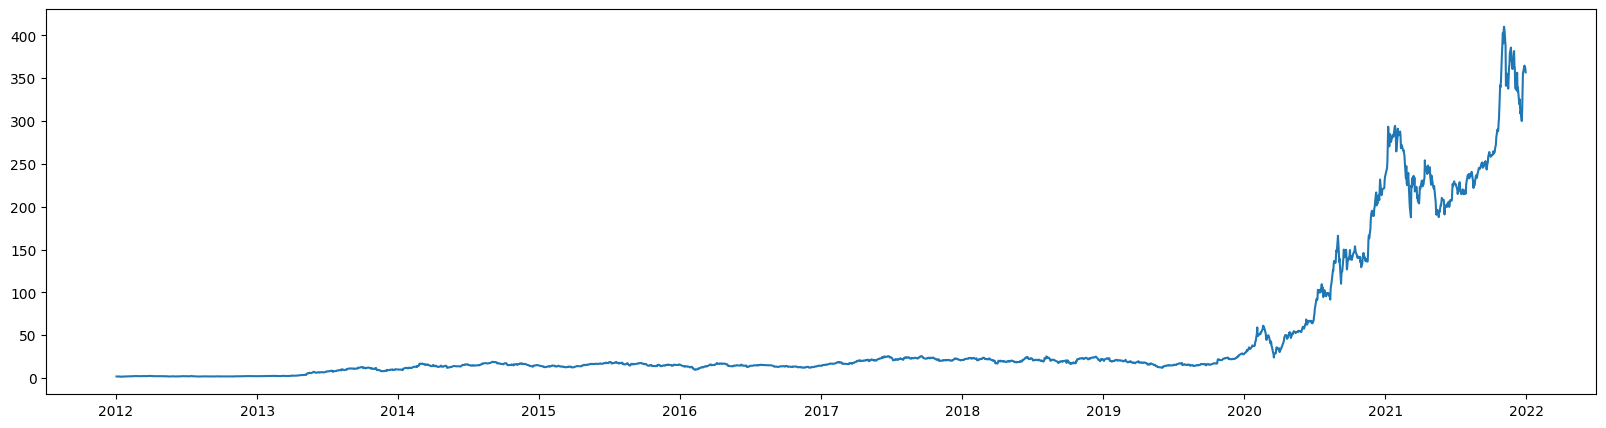

In [7]:
# representamos gráficamente los datos para ver que pinta tienen.
# se representa solamente la columna de Close, que a la vez va a ser nuestra target a predecir
# hay que tener cuidado ya que segun se ve en el grafico los primeros 8 años son bastante planos, sin demasiada fluctuación respecto los últimos 2 años.
# lo que puede pasar es que el modelo se acostumbre a unos datos y que despues no se ajuste bien a los nuevos datos....eso ya se verá.

plt.figure(figsize=(20,5))
plt.plot(df["Close"]);

In [8]:
# se crea dataframe con los datos de Close y las fechas ya que como decíamos antes Close = Target.
# para el modelo que usaremos es la mejor opción. 
# Lo que quiere decir days = 60 es que el modelo , según va a ir avanzando, tendrá en cuenta los últimos 60 días para hacer el cálculo y por lo tanto la predicción.
# El usar solamente la columna de Close, se debe precisamente a eso, calcula una sola columna.

data = df.sort_index(ascending=True, axis=0)
new_dataset = pd.DataFrame(index=range(0,len(df)), columns=["Date", "Close"])

days = 60

for i in range(0, len(data)):
    new_dataset["Date"][i] = data["Date"][i]
    new_dataset["Close"][i] = data["Close"][i]


new_dataset.index= new_dataset.Date 
new_dataset.drop("Date", axis=1, inplace=True)

In [9]:
# Nos aseguramos que los datos tienen el formato que necesitamos que tenga.
new_dataset

,Close
Date,
2012-01-03,1.872
2012-01-04,1.847333
2012-01-05,1.808
2012-01-06,1.794
2012-01-09,1.816667
...,...
2021-12-23,355.666656
2021-12-27,364.646667
2021-12-28,362.823334


In [10]:
# Para nuestro modelo vamos a pasar el DataFrame a un array.
final_dataset = new_dataset.values 

In [11]:
# En este punto dividimos los datos. Se separan en datos para el entrenamiento y datos para la validación del entrenamiento.
# El entrenamiento se lleva un 75% de todo el dataset, mientras que la validación será menor.
# Cuantos mas datos tenga el modelo para entrenar mucho mejor.

train_data = final_dataset[0:2000, :]
valid_data = final_dataset[2000: , :]

In [12]:
# Nos aseguramos que no ha cambiado la estructura
train_data

array([[1.872],
       [1.847333],
       [1.808],
       ...,
       [23.256001],
       [23.513332],
       [23.978666]], dtype=object)

In [13]:
# Nos aseguramos que todo está correcto.
valid_data

array([[23.892668],
       [25.433332],
       [25.266001],
       [26.209999],
       [26.936001],
       [27.039333],
       [27.948],
       [28.35],
       [28.729334],
       [28.691999],
       [27.646667],
       [27.888666],
       [28.684],
       [29.534],
       [30.102667],
       [31.270666],
       [32.809334],
       [32.089333],
       [31.876667],
       [34.990665],
       [35.861332],
       [34.566666],
       [34.232666],
       [34.033333],
       [36.48],
       [37.970669],
       [38.146667],
       [37.654667],
       [37.201332],
       [37.793331],
       [38.732666],
       [42.720669],
       [43.371334],
       [52.0],
       [59.137333],
       [48.98],
       [49.930668],
       [49.871334],
       [51.418667],
       [51.625332],
       [51.152668],
       [53.599998],
       [53.335335],
       [57.226665],
       [61.161331],
       [59.960667],
       [60.066666],
       [55.585999],
       [53.327332],
       [51.919998],
       [45.266666],
      

In [14]:
# Cuando vimos los datos estadísticos del dataframe, nos llamo la antención que habia una gran diferencia entre el mínimo y el máximo.
# Por ese motivo haremos un escalado de los datos que nos devolverá valores entre 0 y 1.
# Esto nos permite que sea resistente ante desviaciones estandar para que el modelo predictivo se ajuste mejor. 

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(final_dataset)

In [15]:
# Comprobamos que el escalado se ha ejecutado correctamente.
scaled_data

array([[8.63426180e-04],
       [8.03034554e-04],
       [7.06736511e-04],
       ...,
       [8.84571943e-01],
       [8.82711229e-01],
       [8.69776190e-01]])

In [16]:
# En este punto es donde vuelve a entrar en juego el ajuste de los 60 días que mencionabamos antes.
# Aqui es donde dividimos los datos que reservamos para el entrenamiento en 2 ejes.

X_train_data, y_train_data = [], []

for i in range(days, len(train_data)):
    X_train_data.append(scaled_data[i-days:i, 0])
    y_train_data.append(scaled_data[i, 0])

In [17]:
# Aplicamos cambios al eje X para convertirlos en un array de 3 dimensiones.

X_train_data, y_train_data =np.array(X_train_data), np.array(y_train_data)
X_train_data = np.reshape(X_train_data, (X_train_data.shape[0], X_train_data.shape[1], 1))

In [18]:
# Comprobamos que los cambios se han realizado 

X_train_data

array([[[0.00086343],
        [0.00080303],
        [0.00070674],
        ...,
        [0.00238462],
        [0.00247276],
        [0.00245807]],

       [[0.00080303],
        [0.00070674],
        [0.00067246],
        ...,
        [0.00247276],
        [0.00245807],
        [0.0023732 ]],

       [[0.00070674],
        [0.00067246],
        [0.00072796],
        ...,
        [0.00245807],
        [0.0023732 ],
        [0.00235851]],

       ...,

       [[0.03591131],
        [0.03623448],
        [0.03602231],
        ...,
        [0.05020272],
        [0.05110369],
        [0.0516978 ]],

       [[0.03623448],
        [0.03602231],
        [0.03652991],
        ...,
        [0.05110369],
        [0.0516978 ],
        [0.05321736]],

       [[0.03602231],
        [0.03652991],
        [0.03555386],
        ...,
        [0.0516978 ],
        [0.05321736],
        [0.05384738]]])

In [19]:
y_train_data.shape

(1940,)

In [20]:
# Se crea el modelo basado en redes neuronales.
# Una capa de entrada , una capa oculta y una capa de salida.
# Es un modelo pensado para trabajar con sequencias. De por si calcula en base al pasado.

lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape = (X_train_data.shape[1], 1)))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units=50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))


In [33]:
# Se compila y entrena el modelo.
# Vemos que el valor que da el "loss" son muy bajos. Por lo tanto es un buen indício.

lstm_model.compile(loss="mean_squared_error", optimizer="adam", metrics = ["accuracy"])
history = lstm_model.fit(X_train_data, y_train_data, epochs=10, batch_size=500, verbose=2)

Epoch 1/10
4/4 - 5s - loss: 1.4666e-04 - accuracy: 0.0000e+00 - 5s/epoch - 1s/step
Epoch 2/10
4/4 - 1s - loss: 1.1270e-04 - accuracy: 0.0000e+00 - 1s/epoch - 327ms/step
Epoch 3/10
4/4 - 2s - loss: 9.5292e-05 - accuracy: 0.0000e+00 - 2s/epoch - 403ms/step
Epoch 4/10
4/4 - 2s - loss: 4.9327e-05 - accuracy: 0.0000e+00 - 2s/epoch - 402ms/step
Epoch 5/10
4/4 - 2s - loss: 4.9429e-05 - accuracy: 0.0000e+00 - 2s/epoch - 410ms/step
Epoch 6/10
4/4 - 2s - loss: 3.1532e-05 - accuracy: 0.0000e+00 - 2s/epoch - 405ms/step
Epoch 7/10
4/4 - 2s - loss: 2.1467e-05 - accuracy: 0.0000e+00 - 2s/epoch - 391ms/step
Epoch 8/10
4/4 - 2s - loss: 2.4664e-05 - accuracy: 0.0000e+00 - 2s/epoch - 396ms/step
Epoch 9/10
4/4 - 2s - loss: 2.1666e-05 - accuracy: 0.0000e+00 - 2s/epoch - 429ms/step
Epoch 10/10
4/4 - 2s - loss: 1.8627e-05 - accuracy: 0.0000e+00 - 2s/epoch - 394ms/step


In [34]:
# Se aprecia muy bien lo bajos que son los valores de loss. En cambio el valor de accuracy sale en 0 y deberia salir lo mas cercano a 1 posible.

pd.DataFrame(history.history)

,loss,accuracy
0,0.000147,0.0
1,0.000113,0.0
2,0.000095,0.0
3,0.000049,0.0
4,0.000049,0.0
5,0.000032,0.0
6,0.000021,0.0
7,0.000025,0.0
8,0.000022,0.0
9,0.000019,0.0


In [23]:
# Ahora toca trabajar los datos del testeo para ver como reacciona ante nuevos datos.
# Se realizan los mismos ajustes y escalado que a las variables de entrenamiento y validación

inputs_data = new_dataset[len(new_dataset)-len(valid_data)-days:].values
inputs_data = inputs_data.reshape(-1,1)
inputs_data = scaler.transform(inputs_data)

In [24]:
# Una vez que hayamos hecho los ajustes sobre los datos toca organizarlos para predecir

X_test =[]

for i in range(days,inputs_data.shape[0]):
    X_test.append(inputs_data[i-days:i,0])
X_test=np.array(X_test)

X_test= np.reshape(X_test,(X_test.shape[0], X_test.shape[1]))

In [25]:
# Se confirma que los datos de test tienen el formato adecuado para la predicción
X_test

array([[0.03652991, 0.03555386, 0.03565343, ..., 0.05321736, 0.05384738,
        0.05498665],
       [0.03555386, 0.03565343, 0.03271223, ..., 0.05384738, 0.05498665,
        0.0547761 ],
       [0.03565343, 0.03271223, 0.0336083 , ..., 0.05498665, 0.0547761 ,
        0.05854807],
       ...,
       [0.62893114, 0.63408068, 0.6333135 , ..., 0.81961104, 0.86705042,
        0.88903597],
       [0.63408068, 0.6333135 , 0.63507626, ..., 0.86705042, 0.88903597,
        0.88457194],
       [0.6333135 , 0.63507626, 0.64393908, ..., 0.88903597, 0.88457194,
        0.88271123]])

In [26]:
# Se realiza la predicción con los datos de test que ajustamos mas arriba

closing_price = lstm_model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

17/17 [==============================] - 2s 20ms/step


In [32]:
closing_price

array([[ 24.036858],
       [ 24.120277],
       [ 24.250383],
       [ 24.408453],
       [ 24.60629 ],
       [ 24.846498],
       [ 25.11515 ],
       [ 25.420383],
       [ 25.755356],
       [ 26.113632],
       [ 26.479933],
       [ 26.818518],
       [ 27.133972],
       [ 27.443672],
       [ 27.762249],
       [ 28.09378 ],
       [ 28.455315],
       [ 28.867815],
       [ 29.291832],
       [ 29.709465],
       [ 30.186827],
       [ 30.71888 ],
       [ 31.24864 ],
       [ 31.756117],
       [ 32.230194],
       [ 32.726517],
       [ 33.263668],
       [ 33.82333 ],
       [ 34.37524 ],
       [ 34.897694],
       [ 35.400005],
       [ 35.89811 ],
       [ 36.47666 ],
       [ 37.118073],
       [ 37.99685 ],
       [ 39.20324 ],
       [ 40.386173],
       [ 41.544018],
       [ 42.65393 ],
       [ 43.738117],
       [ 44.782516],
       [ 45.7614  ],
       [ 46.726295],
       [ 47.65255 ],
       [ 48.620518],
       [ 49.6911  ],
       [ 50.78601 ],
       [ 51.8

In [27]:
# Vamos a usar los datos de predicction para hacer un gráfico y ver mejor los resultados.

train_data = new_dataset[:2000]
valid_data = new_dataset[2000:]
valid_data["Prediction"]= closing_price

C:\Users\Bogdan\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


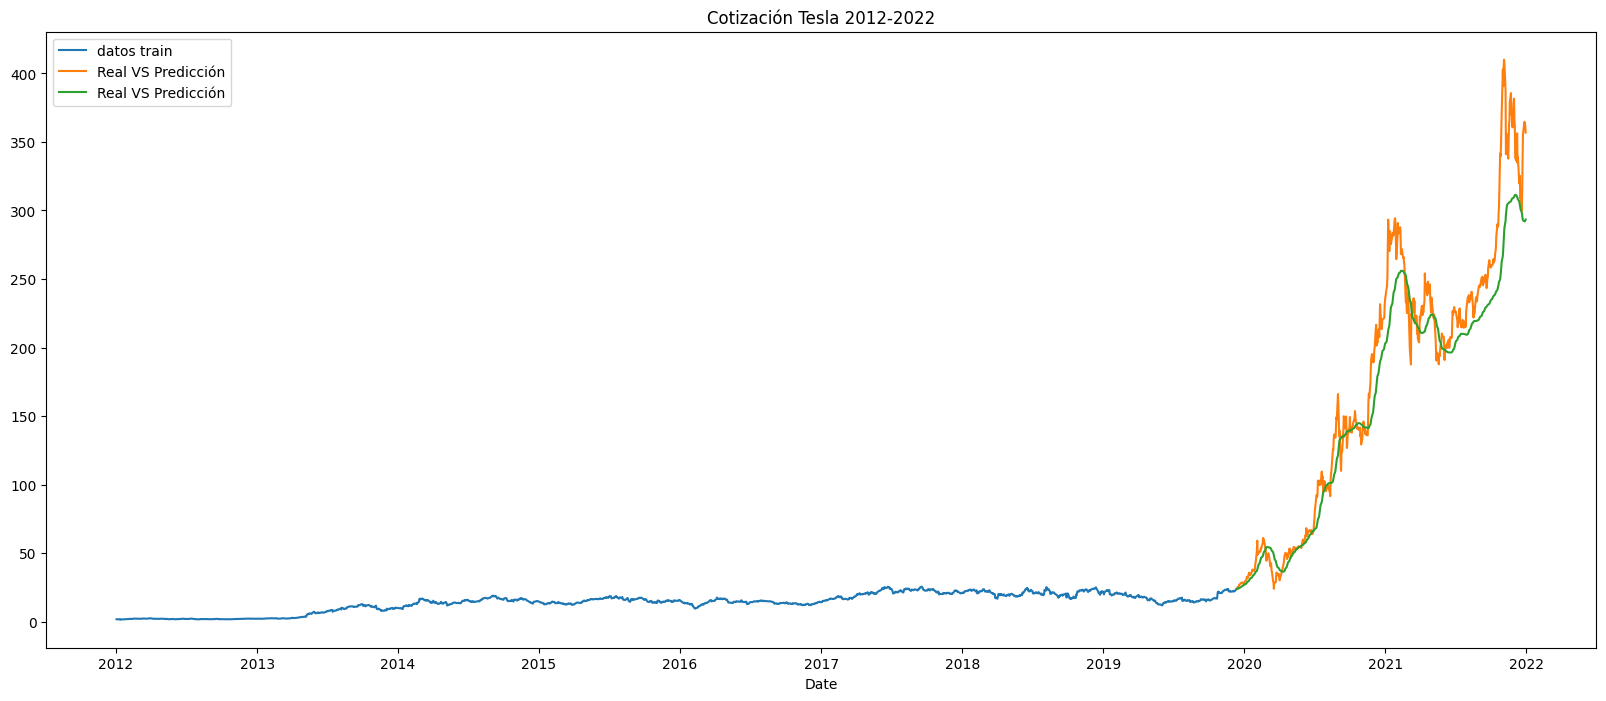

In [28]:
# Visualizamos los datos con los que empezamos y le añadimos la predicción para ver lo lejos o cerca que está de los datos tenidos en cuenta.

plt.figure(figsize=(20,8))

plt.plot(train_data["Close"], label="datos train")
plt.plot(valid_data[["Close","Prediction"]], label="Real VS Predicción")

plt.xlabel("Date")
plt.title("Cotización Tesla 2012-2022")
plt.legend()
plt.show()


In [29]:
# guardamos el modelo.

# import pickle

# with open('models/production/modelotesla.model', "wb") as archivo_salida:
#     pickle.dump(lstm_model, archivo_salida)